# Import

In [1]:
# Graphics
import matplotlib.pyplot as plt

# Pandas & ML
import numpy as np
import pandas as pd
import seaborn as sns

sns.set()

# Third party
import mlflow
import shap

# from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from mlflow.models import infer_signature

# Pandas & ML
from sklearn import metrics
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler, StandardScaler

In [112]:
from sklearn.ensemble import RandomForestClassifier

# Split train/test
To keep some test data not seen by gridsearch

In [2]:
# load cleaned data
app_train = pd.read_pickle("../data/processed/app_train_cleaned.pkl").set_index(
    "SK_ID_CURR"
)

In [3]:
app_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 307511 entries, 100002 to 456255
Columns: 245 entries, NAME_CONTRACT_TYPE to FE_PAYMENT_RATE
dtypes: bool(132), float64(71), int64(42)
memory usage: 306.2 MB


In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    app_train.drop("TARGET", axis=1), app_train.TARGET, test_size=0.15
)

# Profits and Loss function

In [5]:
def human_format(num: float | int) -> str:
    """
    Format a big number in a human readable way with dollar sign and SI prefixes (k,m,M etc)

    Parameters
    ----------
    num: float | int
        Raw number

    Returns
    -------
    str:
        Human readable number as a string
    """
    num = float("{:.3g}".format(num))
    magnitude = 0
    while abs(num) >= 1000:
        magnitude += 1
        num /= 1000.0
    return "{}{}".format(
        "${:f}".format(num).rstrip("0").rstrip("."), ["", "K", "M", "B", "T"][magnitude]
    )

In [88]:
# compute mean ratio of value of goods, and amount loaned for buying this goods
GOODS_CREDIT_RATIO = (
    app_train[app_train["AMT_GOODS_PRICE"].notna()].AMT_GOODS_PRICE
    / app_train[app_train["AMT_GOODS_PRICE"].notna()].AMT_CREDIT
).mean()


def pnl(
    y_true: "ndarray",
    y_pred: "ndarray",
    interest: "float" = 0.04,
    goods_recover_rate: "float" = 0.30,
    normalize: "bool" = True,
):
    """
    Naive estimation of gains and losses for the bank
    if loans are granted according to model predictions.

    Parameters
    ----------
    y_true: ndarray
        Numpy array of true classes
    y_pred: ndarray
        Numpy array of predictions given by a model (0 or 1)
    interest: float, default 0.04
        Interest rate on credit amount the bank charges when loan is correctly repayed.
        Because this value was not provided in the dataset, we'll use current market tendencies.
    goods_recover_rate: float, default 0.60
        Rate of monetary value recovered on goods seized by the bank for customers that can't repay their loan.
    normalize: True | False, default: True
        If False, returns total gains in dollars for the bank.
        If True (default), returns a 0 to 1 ratio where 1 corresponds to the maximum
        gain possible if all predictions are true (if y_pred == y_true)

    Returns
    -------
    float:
        Total sum of gains and losses for the bank
    """
    # TODO: X en param
    # df.apply(bank_revenue)
    # y_proba
    credit = app_train.loc[X_test.index, "AMT_CREDIT"]
    # when goods value is missing, use 90% of credit amount
    seized_goods = (
        np.where(
            app_train.loc[X_test.index, "AMT_GOODS_PRICE"].notna(),
            app_train.loc[X_test.index, "AMT_GOODS_PRICE"],
            app_train.loc[X_test.index, "AMT_CREDIT"] * GOODS_CREDIT_RATIO,
        )
        * goods_recover_rate
    )
    bank_revenue = pd.Series(np.nan)
    # TP: loan correctly denied = no loss, no gain
    bank_revenue = np.where((y_pred == 1) & (y_true == 1), 0, bank_revenue)
    # FP: loan incorreclty denied: loss of interest
    bank_revenue = np.where(
        (y_pred == 1) & (y_true == 0),
        -credit * interest,
        bank_revenue,
    )
    # TN: loan correcly granted: gain of interest
    bank_revenue = np.where(
        (y_pred == 0) & (y_true == 0),
        credit * interest,
        bank_revenue,
    )
    # FN: loan incorrectly granted: loan amount is lost, customer goods are seized and sold
    bank_revenue = np.where(
        (y_pred == 0) & (y_true == 1),
        -credit + seized_goods,
        bank_revenue,
    )
    if normalize:
        return bank_revenue.sum() / pnl(
            y_true, y_true, interest, goods_recover_rate, normalize=False
        )
    else:
        return bank_revenue.sum()

### Create customer scorer from custom pnl function

In [7]:
from sklearn.metrics._scorer import make_scorer

In [8]:
pnl_scorer = make_scorer(pnl, greater_is_better=True)

# Naive undersampler to fix target imbalance

In [113]:
# def NaiveUnderSampler(df):
#     # find the minority class
#     min_class = df.TARGET.value_counts().idxmin()
#     # keep same number of majority class than minority
#     target_minority_count = df[df.TARGET == min_class].shape[0]
#     df_balanced = pd.concat(
#         [
#             df[df.TARGET == min_class].sample(target_minority_count),
#             df[df.TARGET != min_class].sample(target_minority_count),
#         ]
#     )
#     # shuffle rows
#     return df_balanced.sample(frac=1)

In [9]:
def NaiveUnderSampler(X, y):
    # TODO: docstring
    # find the minority class
    min_class = y.value_counts().idxmin()
    # keep same number of majority class than minority
    target_minority_count = y[y == min_class].shape[0]
    df_balanced = pd.concat(
        [
            X[y == min_class].sample(target_minority_count),
            X[y != min_class].sample(target_minority_count),
        ]
    )
    # shuffle rows
    return df_balanced.sample(frac=1)

In [10]:
# create transformer with fit methods from my function
NaiveUnderSamplerTf = FunctionTransformer(NaiveUnderSampler)

In [131]:
# test naive imbalance fixer
# app_train.pipe(NaiveUnderSampler).TARGET.value_counts()

# Pipeline

In [12]:
# separate target
# X, y = app_train.drop("TARGET", axis=1), app_train.TARGET
# print(X.shape)
# print(y.shape)

In [11]:
model_params = {"max_iter": 500}
pipe = Pipeline(
    [
        ("sampler", RandomUnderSampler()),
        ("imputer", SimpleImputer()),
        ("scaler", MinMaxScaler()),
        ("classifier", LogisticRegression(**model_params)),
    ]
)
pipe

Pipeline(steps=[('sampler', RandomUnderSampler()), ('imputer', SimpleImputer()),
                ('scaler', MinMaxScaler()),
                ('classifier', LogisticRegression(max_iter=500))])

In [113]:
?RandomForestClassifier

Init signature:
RandomForestClassifier(
    n_estimators=100,
    *,
    criterion='gini',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features='sqrt',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    bootstrap=True,
    oob_score=False,
    n_jobs=None,
    random_state=None,
    verbose=0,
    warm_start=False,
    class_weight=None,
    ccp_alpha=0.0,
    max_samples=None,
)
Docstring:     
A random forest classifier.

A random forest is a meta estimator that fits a number of decision tree
classifiers on various sub-samples of the dataset and uses averaging to
improve the predictive accuracy and control over-fitting.
The sub-sample size is controlled with the `max_samples` parameter if
`bootstrap=True` (default), otherwise the whole dataset is used to build
each tree.

Read more in the :ref:`User Guide <forest>`.

Parameters
----------
n_estimators : int, default=100
    The number of trees in the forest.


In [114]:
# grid = GridSearchCV(pipe, param_grid={}, cv=3, n_jobs=-1, verbose=3, scoring=pnl_scorer)
param_grid = [
    {
        "sampler": ["passthrough"],
        # "imputer__strategy": ["mean", "median"],
        "classifier__class_weight": ["balanced"],
        "classifier": [LogisticRegression()],
        "classifier__penalty": ["l1", "l2"],
    },
    {
        "imputer__strategy": ["mean", "median"],
        "scaler": [MinMaxScaler(), StandardScaler()],
        "classifier": [RandomForestClassifier()],
        "classifier__n_estimators": [100, 500],
        "classifier__oob_score": [True, False],
    },
]
grid = GridSearchCV(
    pipe, param_grid=param_grid, cv=3, n_jobs=-1, verbose=3, scoring="roc_auc"
)
grid.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


/home/carl/anaconda3/envs/p7env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/carl/anaconda3/envs/p7env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('sampler', RandomUnderSampler()),
                                       ('imputer', SimpleImputer()),
                                       ('scaler', MinMaxScaler()),
                                       ('classifier',
                                        LogisticRegression(max_iter=500))]),
             n_jobs=-1,
             param_grid=[{'classifier__class_weight': ['balanced'],
                          'sampler': ['passthrough']},
                         {'classifier': [RandomForestClassifier(),
                                         LogisticRegression()],
                          'imputer__strategy': ['mean', 'median'],
                          'scaler': [MinMaxScaler(), StandardScaler()]}],
             scoring='roc_auc', verbose=3)

In [117]:
grid_results = pd.DataFrame(grid.cv_results_)
grid_results
# TODO: log each cv_result to ML FLow

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__class_weight,param_sampler,param_classifier,param_imputer__strategy,param_scaler,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,69.712546,0.915075,1.173884,0.199538,balanced,passthrough,NaN,NaN,NaN,"{'classifier__class_weight': 'balanced', 'samp...",0.743190,0.749416,0.750237,0.747614,0.003146,1
1,33.462857,1.122318,9.946853,1.193247,NaN,NaN,RandomForestClassifier(),mean,MinMaxScaler(),"{'classifier': RandomForestClassifier(), 'impu...",0.728392,0.735927,0.736446,0.733588,0.003680,8
2,33.523089,0.572604,8.994391,0.966064,NaN,NaN,RandomForestClassifier(),mean,StandardScaler(),"{'classifier': RandomForestClassifier(), 'impu...",0.730187,0.735847,0.733317,0.733117,0.002315,9
3,34.210618,0.999062,8.755884,0.754939,NaN,NaN,RandomForestClassifier(),median,MinMaxScaler(),"{'classifier': RandomForestClassifier(), 'impu...",0.730051,0.737342,0.738338,0.735244,0.003694,6
4,35.303410,1.548439,8.876162,0.598341,NaN,NaN,RandomForestClassifier(),median,StandardScaler(),"{'classifier': RandomForestClassifier(), 'impu...",0.729275,0.736961,0.737317,0.734518,0.003710,7
5,10.176002,0.875884,4.129261,0.214467,NaN,NaN,LogisticRegression(),mean,MinMaxScaler(),"{'classifier': LogisticRegression(), 'imputer_...",0.742845,0.748260,0.748455,0.746520,0.002600,5
6,11.370690,0.445431,4.166053,0.070858,NaN,NaN,LogisticRegression(),mean,StandardScaler(),"{'classifier': LogisticRegression(), 'imputer_...",0.742685,0.747949,0.749123,0.746586,0.002799,3
7,12.351981,1.322505,3.271708,0.180037,NaN,NaN,LogisticRegression(),median,MinMaxScaler(),"{'classifier': LogisticRegression(), 'imputer_...",0.742675,0.748586,0.749017,0.746759,0.002893,2
8,11.230648,0.558998,3.586396,0.130823,NaN,NaN,LogisticRegression(),median,StandardScaler(),"{'classifier': LogisticRegression(), 'imputer_...",0.742323,0.749149,0.748177,0.746550,0.003015,4


In [158]:
model = grid.best_estimator_
y_pred = grid.predict(X_test)
model

Pipeline(steps=[('sampler', 'passthrough'), ('imputer', SimpleImputer()),
                ('scaler', MinMaxScaler()),
                ('classifier',
                 LogisticRegression(class_weight='balanced', max_iter=500))])

In [127]:
# local server must be running: $ mlflow ui
mlflow.set_tracking_uri(uri="http://127.0.0.1:5000")
mlflow.set_experiment("P7 ML")
# mlflow.sklearn.autolog()  # log only sklearn model, not shap etc

<Experiment: artifact_location='mlflow-artifacts:/132287291501882802', creation_time=1708695008003, experiment_id='132287291501882802', last_update_time=1708695008003, lifecycle_stage='active', name='P7 ML', tags={}>

In [ ]:
# Log best model in MLFlow
with mlflow.start_run(nested=True):
    # Log the hyperparameters
    mlflow.log_params(model.get_params())
    # Log the loss metric
    # mlflow.log_metric("accuracy", metrics.accuracy_score(y_test, y_pred))
    mlflow.log_metric("roc_auc", metrics.roc_auc_score(y_test, y_pred))
    # mlflow.log_metric("custom_pnl", pnl(y_pred, y_test))

    # Set a tag that we can use to remind ourselves what this run was for
    # mlflow.set_tag("Description", "Basic LR model for iris data")

    # Infer the model signature
    signature = infer_signature(X_train, model.predict(X_train))

    # Log dataset
    dataset = mlflow.data.from_pandas(X_train)
    mlflow.log_input(dataset, context="train")

    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=model,
        artifact_path="P7_model",
        signature=signature,
        # input_example=dataset,
        # registered_model_name="tracking-quickstart",
    )

    # Log results from other gridsearch candidates
    for candidate in grid_results[["params", "mean_fit_time", "mean_test_score"]].values:
        with mlflow.start_run(nested=True):
            mlflow.log_input(dataset, context="train")
            mlflow.log_params(candidate[0])
            mlflow.set_tag("duration", candidate[1])
            mlflow.log_metric("roc_auc", candidate[2])
mlflow.end_run()

# Proba predict treshold

In [42]:
# faire varier seuil et afficher graphiquement resultats

In [58]:
model

Pipeline(steps=[('sampler', 'passthrough'), ('imputer', SimpleImputer()),
                ('scaler', MinMaxScaler()),
                ('classifier',
                 LogisticRegression(class_weight='balanced', max_iter=500))])

In [98]:
res_roc_auc = pd.Series()
res_accuracy = pd.Series()
res_pnl = pd.Series()
for threshold in np.linspace(0, 1, 20):
    y_pred_threshold = (
        model.predict_proba(
            X_test,
        )[:, 1]
        >= threshold
    ).astype(int)
    res_roc_auc.loc[threshold] = metrics.roc_auc_score(y_test, y_pred_threshold)
    res_accuracy.loc[threshold] = metrics.accuracy_score(y_test, y_pred_threshold)
    res_pnl.loc[threshold] = pnl(y_test, y_pred_threshold)

In [145]:
res_roc_auc.idxmax()

0.4897959183673469

In [146]:
res_roc_auc.max()

0.6867648314453287

In [101]:
res_pnl.idxmax()

0.631578947368421

In [100]:
res_pnl.describe()

count    20.000000
mean     -0.281659
std       0.385563
min      -1.000000
25%      -0.531622
50%      -0.134271
75%       0.008883
max       0.098764
dtype: float64

[]

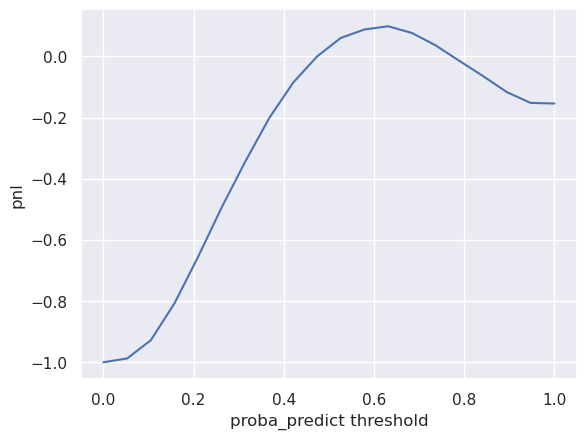

In [99]:
ax = res_pnl.plot()
plt.xlabel("proba_predict threshold")
plt.ylabel("pnl")
plt.plot()
# ax = res_accuracy.plot()
# TODO: use pnl as y-axis

[]

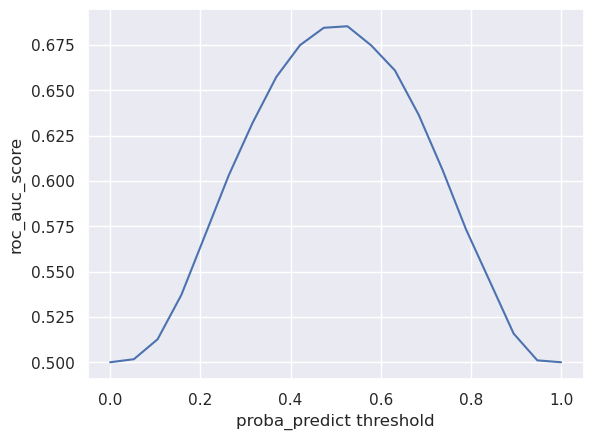

In [102]:
ax = res_roc_auc.plot()
plt.xlabel("proba_predict threshold")
plt.ylabel("roc_auc_score")
plt.plot()
# ax = res_accuracy.plot()
# TODO: use pnl as y-axis

<Axes: >

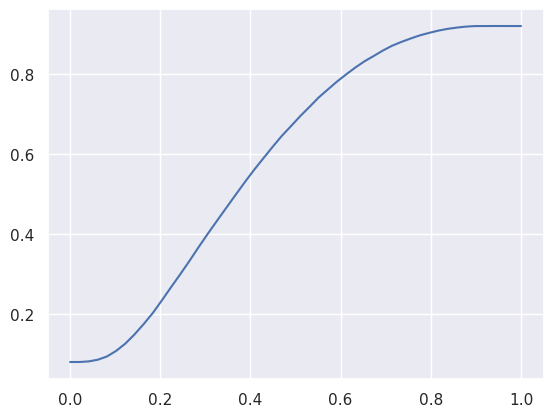

In [92]:
res_accuracy.plot()

# Scoring metric

In [46]:
y_pred.mean()

0.3461530123355085

In [47]:
metrics.accuracy_score(y_test, y_pred)

0.6842846922626661

In [48]:
metrics.roc_auc_score(y_test, y_pred)

0.6867228658830676

Sensibilité : 1.00
Spécificité : 0.00
Seuil : 0.00


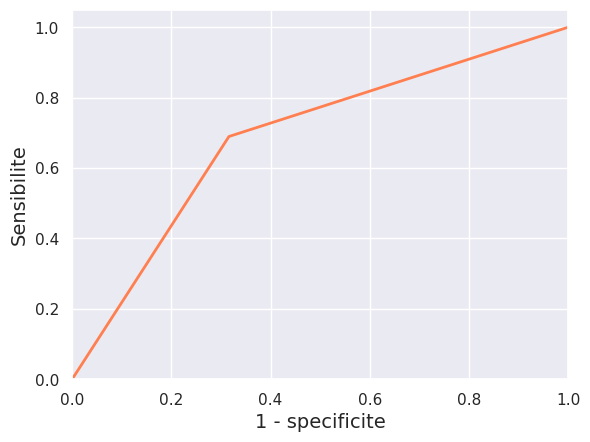

In [49]:
[fpr, tpr, thr] = metrics.roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, color="coral", lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("1 - specificite", fontsize=14)
plt.ylabel("Sensibilite", fontsize=14)

# indice du premier seuil pour lequel
# la sensibilité est supérieure à 0.95
idx = np.min(np.where(tpr > 0.95))

print("Sensibilité : {:.2f}".format(tpr[idx]))
print("Spécificité : {:.2f}".format(1 - fpr[idx]))
print("Seuil : {:.2f}".format(thr[idx]))

### Custom PnL

In [54]:
print("P&L avec prédictions modèle : ", pnl(y_pred, y_test))
print("P&L avec prédictions parfaites : ", pnl(y_test, y_test))

P&L avec prédictions modèle :  0.03753863397008134
P&L avec prédictions parfaites :  1.0


In [62]:
metrics.roc_auc_score(y_pred, y_test)

0.5613626457790191

In [55]:
print(
    "P&L avec prédictions modèle : ", human_format(pnl(y_pred, y_test, normalize=False))
)
print(
    "P&L avec prédictions parfaites : ",
    human_format(pnl(y_test, y_test, normalize=False)),
)

P&L avec prédictions modèle :  $38.1M
P&L avec prédictions parfaites :  $1.01B


In [51]:
# mlflow.log_metric("custom_pnl", pnl(y_pred, y_test))

In [52]:
y_pred.mean()

0.3461530123355085

In [53]:
y_test.mean()

0.08025668263706723

# Track model with MLFlow

In [144]:
# local server must be running:
# $ mlflow ui
mlflow.set_tracking_uri(uri="http://127.0.0.1:5000")
mlflow.set_experiment("P7 ML")
# mlflow.sklearn.autolog()  # log only sklearn model, not shap etc

# Start an MLflow run
with mlflow.start_run():
    # Log the hyperparameters
    mlflow.log_params(model_params)

    # Log the loss metric
    mlflow.log_metric("accuracy", metrics.accuracy_score(y_test, y_pred))
    mlflow.log_metric("roc_auc", metrics.roc_auc_score(y_test, y_pred))
    mlflow.log_metric("custom_pnl", pnl(y_pred, y_test))

    # Set a tag that we can use to remind ourselves what this run was for
    # mlflow.set_tag("Description", "Basic LR model for iris data")

    # Infer the model signature
    signature = infer_signature(X_train, model.predict(X_train))

    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=model,
        artifact_path="P7_model",
        signature=signature,
        input_example=X_train,
        # registered_model_name="tracking-quickstart",
    )

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.


## Essai non concluant : calculer intérêts et durée du prêt en fonction du montant total et de l'annuity

In [31]:
app_train[["AMT_CREDIT", "AMT_ANNUITY", "AMT_GOODS_PRICE"]].sample(10)

,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE
SK_ID_CURR,,,
264232,180000.0,9000.0,180000.0
281527,1711368.0,70758.0,1597500.0
375874,973710.0,25816.5,697500.0
249631,225000.0,11250.0,225000.0
207138,1379376.0,36517.5,1080000.0
303536,314100.0,16573.5,225000.0
236871,115128.0,12528.0,108000.0
279827,640764.0,17617.5,459000.0
166967,900000.0,24880.5,900000.0


In [32]:
(app_train.AMT_ANNUITY / app_train.AMT_CREDIT).describe()

# app_train.AMT_CREDIT * 1.0665 / app_train.AMT_ANNUITY

count    307499.000000
mean          0.053695
std           0.022481
min           0.022073
25%           0.036900
50%           0.050000
75%           0.064043
max           0.124430
dtype: float64

# Shap values

In [33]:
explainer = shap.LinearExplainer(grid.best_estimator_["classifier"], X_train)
shap_values = explainer.shap_values(X_test)
shap_values

array([[0.001561305267766127, 0.09097276185909246, 0.010487651127741825,
        ..., 2363.8564346161434, 0.14292272517024993,
        -0.012744650173650828],
       [0.001561305267766127, -0.1617293544161644, 0.010487651127741825,
        ..., 967.8095221010727, -0.0324521569071178,
        -0.03949068188670004],
       [0.001561305267766127, -0.1617293544161644, 0.010487651127741825,
        ..., 7948.044084676426, 0.2581056941017382, 0.021412448096166194],
       ...,
       [0.001561305267766127, 0.09097276185909246, 0.010487651127741825,
        ..., 7948.044084676426, -0.15863662347747212,
        0.003546091730118546],
       [0.001561305267766127, 0.09097276185909246, 0.010487651127741825,
        ..., 14928.27864725178, 0.07126372947173622,
        0.018420590798360427],
       [0.001561305267766127, -0.1617293544161644, 0.010487651127741825,
        ..., 11438.161365964103, 0.10231226779872803,
        0.018356049468852196]], dtype=object)

In [34]:
X_train.sample()

,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,...,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,FE_DAYS_EMPLOYED_PERC,FE_INCOME_CREDIT_PERC,FE_INCOME_PER_PERSON,FE_ANNUITY_INCOME_PERC,FE_PAYMENT_RATE
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
162240,0,0,1,0,180000.0,568800.0,15133.5,450000.0,0.018801,-11749,...,True,False,False,True,False,0.028598,0.316456,90000.0,0.084075,0.026606


In [35]:
len(shap_values)

46127

In [36]:
model = grid.best_estimator_

Pipeline(steps=[('sampler', RandomUnderSampler()), ('imputer', SimpleImputer()),
                ('scaler', MinMaxScaler()),
                ('classifier', LogisticRegression(max_iter=500))])

In [37]:
X_test.shape

(46127, 244)

In [38]:
X_test.shape

(46127, 244)

In [39]:
idx = X_test.sample().index[0]

In [40]:
X_test.loc[X_test.sample().index[0], :]

NAME_CONTRACT_TYPE               0
FLAG_OWN_CAR                     1
FLAG_OWN_REALTY                  0
CNT_CHILDREN                     1
AMT_INCOME_TOTAL          157500.0
                            ...   
FE_DAYS_EMPLOYED_PERC     0.331917
FE_INCOME_CREDIT_PERC     0.231788
FE_INCOME_PER_PERSON       52500.0
FE_ANNUITY_INCOME_PERC    0.171086
FE_PAYMENT_RATE           0.039656
Name: 444669, Length: 244, dtype: object

In [41]:
def shap_for_one(df, idx):
    """
    Return 10 top
    """
    shap_for_sample = pd.DataFrame(explainer.shap_values(df.loc[idx, :])).fillna(0)
    shap_OK = StandardScaler().fit_transform(shap_for_sample)
    shap_OK = pd.DataFrame(shap_OK, index=df.columns)
    shap_OK = pd.Series(shap_OK.iloc[:, 0])
    top_shap = shap_OK.sort_values(ascending=False).head(10)
    bottom_shap = shap_OK.sort_values(ascending=True).head(10)
    return {"top": top_shap.to_dict(), "bottom": bottom_shap.to_dict()}


shap_for_one(X_test, X_test.sample().index[0])

{'top': {'AMT_CREDIT': 6.105992844088763,
  'FE_INCOME_PER_PERSON': 0.6196442049132869,
  'AMT_ANNUITY': 0.35879639277025577,
  'AMT_INCOME_TOTAL': 0.29895649344110947,
  'DAYS_BIRTH': 0.030136130016934666,
  'DAYS_LAST_PHONE_CHANGE': 0.029806703998635237,
  'DAYS_ID_PUBLISH': 0.02955654133512838,
  'CODE_GENDER_M': 0.029141785074474933,
  'EXT_SOURCE_2': 0.029140530831497077,
  'NAME_INCOME_TYPE_Commercial associate': 0.029140349403738795},
 'bottom': {'AMT_GOODS_PRICE': -14.349624843301797,
  'DAYS_REGISTRATION': 0.02891426614950176,
  'FLAG_DOCUMENT_3': 0.029137968484059387,
  'NAME_EDUCATION_TYPE_Secondary / secondary special': 0.029138788765212767,
  'CODE_GENDER_F': 0.0291389237115336,
  'HOUR_APPR_PROCESS_START': 0.029138982293111695,
  'NAME_INCOME_TYPE_Working': 0.02913899336912268,
  'FE_ANNUITY_INCOME_PERC': 0.02913905619428112,
  'FLAG_EMP_PHONE': 0.029139214098371554,
  'CNT_FAM_MEMBERS': 0.029139293010302058}}

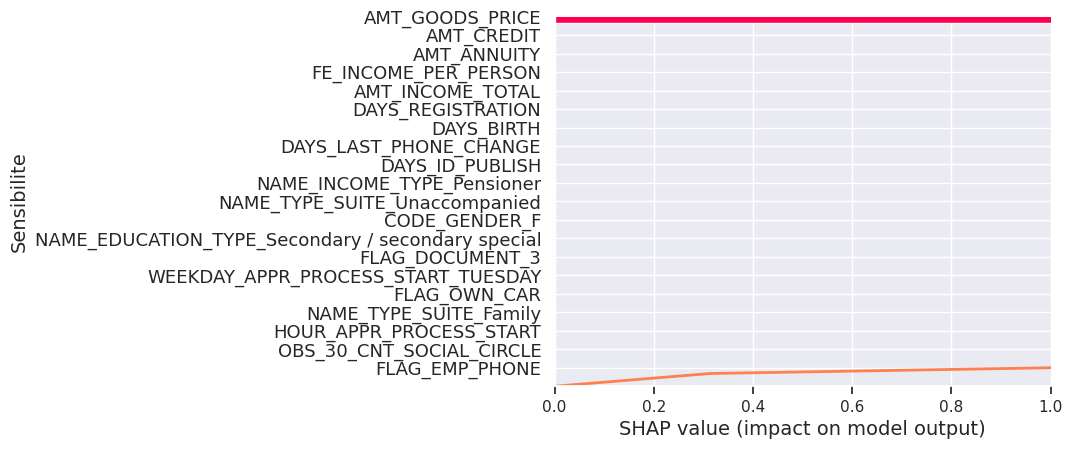

In [42]:
shap_dict = shap_for_one(X_test, X_test.sample().index[0])
# merge top and bottom into one dict
shap_dict["top"].update(shap_dict["bottom"])
keys = np.fromiter(shap_dict["top"].keys(), dtype=object)
values = np.fromiter(shap_dict["top"].values(), dtype=float)
shap.bar_plot(
    values,
    feature_names=keys,
    max_display=20,
)

In [43]:
np.fromiter(shap_dict["top"].keys(), dtype=object)

array(['AMT_GOODS_PRICE', 'FLAG_EMP_PHONE', 'OBS_30_CNT_SOCIAL_CIRCLE',
       'HOUR_APPR_PROCESS_START', 'NAME_TYPE_SUITE_Family',
       'FLAG_OWN_CAR', 'WEEKDAY_APPR_PROCESS_START_TUESDAY',
       'FLAG_DOCUMENT_3',
       'NAME_EDUCATION_TYPE_Secondary / secondary special',
       'CODE_GENDER_F', 'AMT_CREDIT', 'AMT_ANNUITY',
       'FE_INCOME_PER_PERSON', 'AMT_INCOME_TOTAL', 'DAYS_REGISTRATION',
       'DAYS_BIRTH', 'DAYS_LAST_PHONE_CHANGE', 'DAYS_ID_PUBLISH',
       'NAME_INCOME_TYPE_Pensioner', 'NAME_TYPE_SUITE_Unaccompanied'],
      dtype=object)

In [44]:
explainer.shap_values(X_test.sample(1))[0]

array([0.001561305267766127, 0.09097276185909246, -0.02447118596473092,
       -0.031114826104597485, -3687.0856205195773, 189847.38246444397,
       -19574.439506580507, 154873.23825356996, 0.00032216912810857564,
       -532.2396985682165, nan, 590.8657741870753, -287.49799016464743,
       nan, 0.0, 0.46280293099810355, -0.030266349190295548,
       -0.0035772172412852784, 0.012249013803795795,
       0.0023809784057678566, -0.008409593561776882, 0.029806085124881292,
       -0.06459090329418395, -0.3745238994963215, 0.0028214670053932646,
       -0.005770075829866737, 0.004740838142803497, -0.018349392331492645,
       0.02887704480208882, -0.017945727734962166, nan,
       0.47880495465013057, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, -0.20177166695351012,
       -0.03960720205141187, 

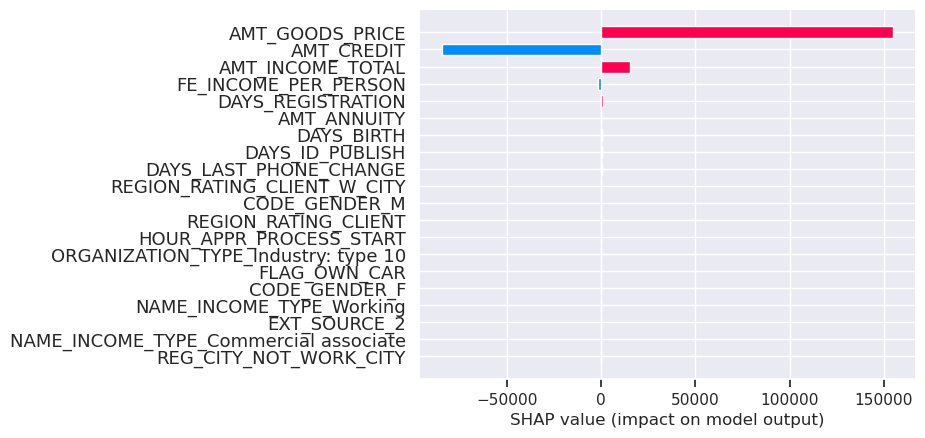

In [45]:
# explainer for only 1 sample row
# TODO prendre que les tops
shap.bar_plot(
    explainer.shap_values(X_test.sample(1))[0],
    feature_names=X_test.columns,
    max_display=20,
)

In [46]:
# shap.plots.beeswarm(explainer.shap_values(X_test))

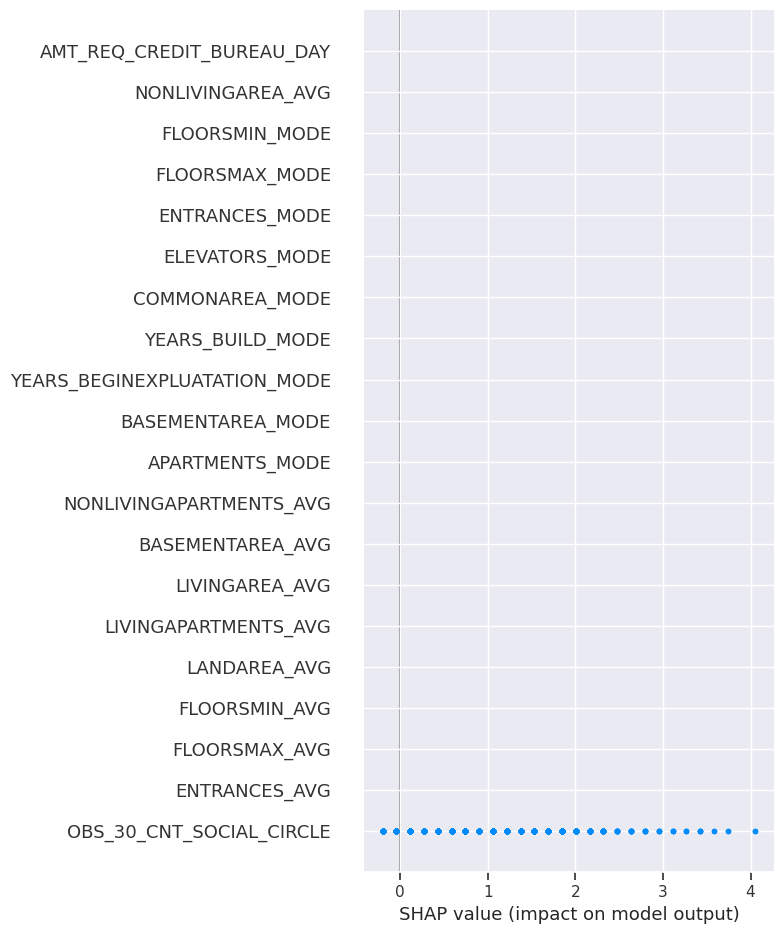

In [47]:
shap.summary_plot(
    explainer.shap_values(X_test).astype(float),
    feature_names=X_test.columns,
    # use_log_scale=True,
)

# Save trained model

In [48]:
# Standard
import pickle

with open("../models/model.pkl", "wb") as f:
    pickle.dump(grid.best_estimator_, f)
with open("../models/shap_explainer.pkl", "wb") as f:
    pickle.dump(explainer, f)

f.close()

In [49]:
grid.best_estimator_.predict_proba(pd.DataFrame(X_test.iloc[0, :]).T)

array([[0.69692256, 0.30307744]])